# Amazon Fine Food Reviews Analysis
The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

 Number of reviews: 568,454                                                                                                     
 Number of users: 256,059                                                                                                       
 Number of products: 74,258                                                                                                                                                                                                             
 Number of Attributes/Columns in data: 10
 
 Attributes:
1. IdRow Id
2. ProductIdUnique identifier for the product
3. UserIdUnqiue identifier for the user
4. ProfileNameProfile name of the user
5. HelpfulnessNumeratorNumber of users who found the review helpful
6. HelpfulnessDenominatorNumber of users who indicated whether they found the review helpful
7. ScoreRating between 1 and 5
8. TimeTimestamp for the review
9. SummaryBrief summary of the review
10. TextText of the review

In [27]:
import warnings
warnings.filterwarnings("ignore")

In [28]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import sqlite3
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
import pickle

In [29]:
# Loading 250 pts obtained after data preprocessing and sorting 

with open('C:/Users/U6069188/Python Projects/Pickle/FilteredData_250K','rb') as f:
    FilteredData = pickle.load(f)

In [30]:
FilteredData = FilteredData.head(50000)

FilteredData["Score"].value_counts()

positive    42540
negative     7460
Name: Score, dtype: int64

In [31]:
#Score as positive/negative -> 0/1
def polarity(x):
    if x == "positive":
        return 1
    else:
        return -1

FilteredData["Score"] = FilteredData["Score"].map(polarity)

FilteredData["Score"].value_counts()

 1    42540
-1     7460
Name: Score, dtype: int64

In [32]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(FilteredData['CleanedText'].values, FilteredData['Score'].values, train_size=.7)

In [33]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train):
#     print("%s %s" % (train, cv))
    print(X_train[train].shape, X_train[cv].shape)

(3190,) (3181,)
(6371,) (3181,)
(9552,) (3181,)
(12733,) (3181,)
(15914,) (3181,)
(19095,) (3181,)
(22276,) (3181,)
(25457,) (3181,)
(28638,) (3181,)
(31819,) (3181,)


In [34]:
from sklearn.datasets import *
from sklearn.svm import SVC
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
from sklearn.linear_model import SGDClassifier
import pandas as pd
import seaborn as sns       
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import randint as sp_randint
import graphviz 
from sklearn.externals.six import StringIO
from sklearn import tree
import pydotplus
from IPython.display import Image

def RunDT_CV(X_train, y_train):
    g = sp_randint(2,100)
    #sorted(g.rvs(30))
    params = {'max_depth' : list(np.arange(1,40,2))}
    model_grid = GridSearchCV(DecisionTreeClassifier(min_samples_split=2, min_samples_leaf=1),param_grid = params,cv=10,scoring='f1')
    model_grid.fit(X_train, y_train)
    
    print(model_grid.best_estimator_)
    optimal_depth = list(model_grid.best_estimator_.get_params().items())[2]
    print(optimal_depth)
    mean_test_scores = model_grid.cv_results_['mean_test_score']
    MSE = [1 - x for x in mean_test_scores]
    
    # plot misclassification error vs depth
    plt.plot(params['max_depth'], MSE, marker = '*') 

    plt.title("Misclassification Error vs depth")
    plt.xlabel('value of depth')
    plt.ylabel('Misclassification Error')
    plt.show()
    
    return optimal_depth[1]
    
def Run_DT(X_train, y_train,X_test,y_test,optimal_depth):
    
    model = DecisionTreeClassifier(class_weight='balanced',max_depth = optimal_depth);
    
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    #Accuracy on train data
    train_acc = model.score(X_train, y_train)
    train_err = 1-train_acc
        
    #Accuracy on test data
    test_acc = accuracy_score(y_test, pred)*100
    test_err = 1- test_acc
        
    print('*'*120)
    print('Optimal depth is' ,optimal_depth)
    print('Accuracy for Decision Tree algorithm is ' ,np.round((accuracy_score(y_test, pred)*100),decimals = 2))
    print('F1 score for Decision Tree is ' , np.round((f1_score(y_test, pred,average= 'macro')*100),decimals = 2))
    print('Recall for Decision Tree is ' , np.round((recall_score(y_test, pred,average= 'macro')*100),decimals = 2))
    print('Precision for Decision Tree is ' , np.round((precision_score(y_test, pred,average= 'macro')*100),decimals = 2))
    print ('\n Classification report for Decision Tree is \n ' , classification_report(y_test,pred))
    
    cm= confusion_matrix(y_test, pred)
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    return train_err,test_err,model

def Tree(X_train, y_train,bow,name) :
    model = DecisionTreeClassifier(class_weight='balanced',max_depth = 3)
    model.fit(X_train, y_train)
    
    dot_data = StringIO()
    tree.export_graphviz(model,out_file=dot_data,feature_names=bow.get_feature_names(),class_names=np.array(['positive','negative']),filled=True, rounded=True,special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    graph.write_png(name)
    
def feature_importance(model,features):
    # Calculate feature importances from decision trees
    importances = model.feature_importances_
    
    # Sort feature importances in descending order
    indices = np.argsort(importances)[::-1][:15]
    
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    
    # Create plot
    plt.figure()

    # Create plot title
    plt.title("Feature Importance")

    # Add bars
    plt.bar(range(15), importances[indices])

    # Add feature names as x-axis labels
    features = np.array(features)
    plt.xticks(range(15), features[indices], rotation=90)

    # Show plot
    plt.show()

# BOW

In [35]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn import preprocessing

bow = CountVectorizer(binary = True).fit(X_train)

In [36]:
X_train_bow = bow.transform(X_train)
X_train_bow.shape

(35000, 23858)

In [37]:
X_test_bow = bow.transform(X_test)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
('max_depth', 15)


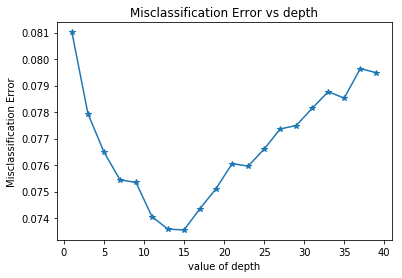

In [38]:
optimal_depth_bow = RunDT_CV(X_train_bow, y_train)

************************************************************************************************************************
Optimal depth is 15
Accuracy for Decision Tree algorithm is  76.01
F1 score for Decision Tree is  65.5
Recall for Decision Tree is  73.75
Precision for Decision Tree is  64.21

 Classification report for Decision Tree is 
                precision    recall  f1-score   support

          -1       0.35      0.71      0.46      2214
           1       0.94      0.77      0.85     12786

   micro avg       0.76      0.76      0.76     15000
   macro avg       0.64      0.74      0.66     15000
weighted avg       0.85      0.76      0.79     15000



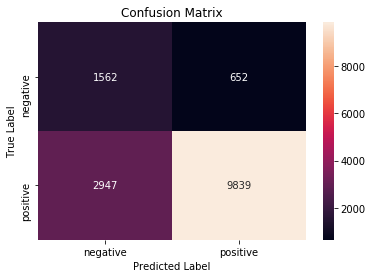

In [39]:
train_err_bow,test_err_bow,model_bow = Run_DT(X_train_bow, y_train,X_test_bow,y_test,optimal_depth_bow)

In [40]:
Tree(X_train_bow, y_train,bow,"Bow_DT.png")

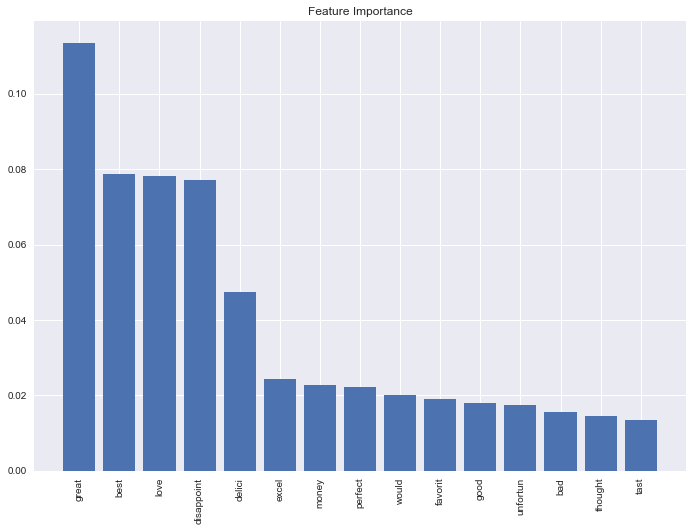

In [41]:
feature_importance(model_bow,bow.get_feature_names())

# Tf-Idf

In [42]:
tfidf = TfidfVectorizer(ngram_range=(1,2),min_df = 5).fit(X_train)

In [43]:
X_train_tfidf = tfidf.transform(X_train)

In [44]:
X_test_tfidf= tfidf.transform(X_test)

In [45]:
X_train_tfidf.shape

(35000, 47239)

In [46]:
X_test_tfidf.shape

(15000, 47239)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=19,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
('max_depth', 19)


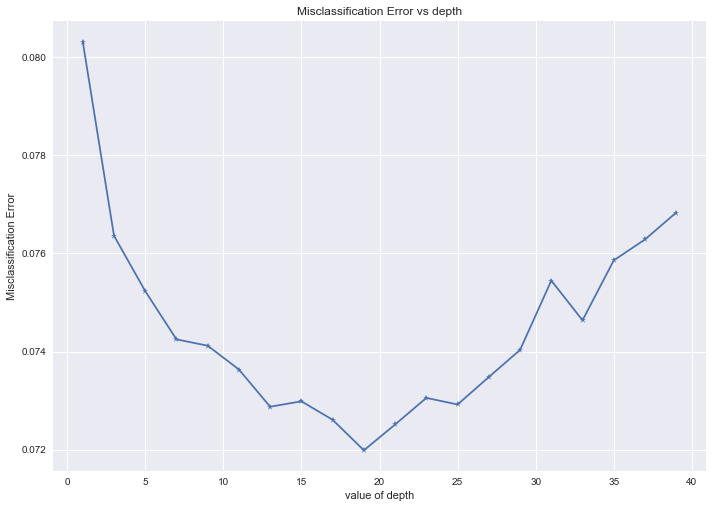

In [47]:
optimal_depth_tfidf = RunDT_CV(X_train_tfidf, y_train)

************************************************************************************************************************
Optimal depth is 19
Accuracy for Decision Tree algorithm is  76.33
F1 score for Decision Tree is  65.62
Recall for Decision Tree is  73.51
Precision for Decision Tree is  64.24

 Classification report for Decision Tree is 
                precision    recall  f1-score   support

          -1       0.35      0.70      0.46      2214
           1       0.94      0.78      0.85     12786

   micro avg       0.76      0.76      0.76     15000
   macro avg       0.64      0.74      0.66     15000
weighted avg       0.85      0.76      0.79     15000



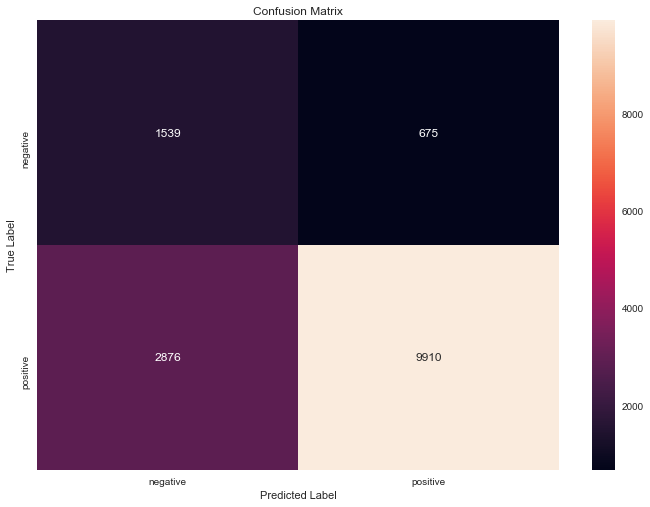

In [48]:
train_err_tfidf,test_err_tfidf,model_tfidf = Run_DT(X_train_tfidf, y_train,X_test_tfidf,y_test,optimal_depth_tfidf)

In [49]:
Tree(X_train_tfidf, y_train,tfidf,"TfIdf_DT.png")

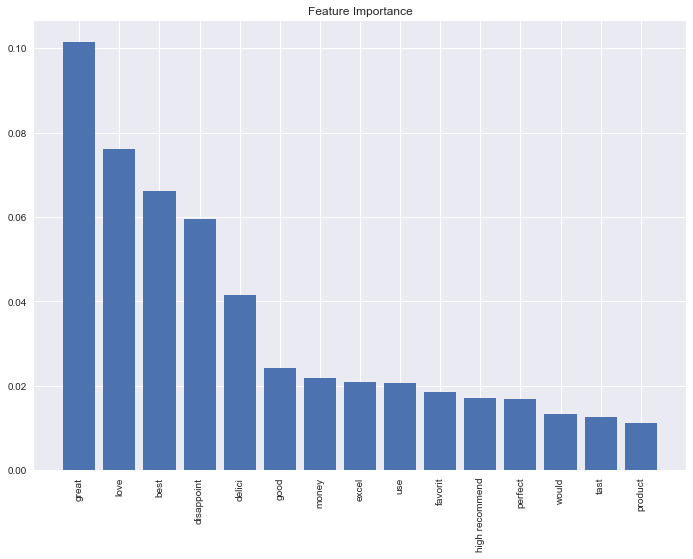

In [50]:
feature_importance(model_tfidf,tfidf.get_feature_names())

# AvgW2V

In [51]:
with open('C:/Users/U6069188/Python Projects/Pickle/AvgW2V','rb') as f:
    AvgW2V = pickle.load(f)

In [52]:
# Loading 250 pts obtained after data preprocessing and sorting 

with open('C:/Users/U6069188/Python Projects/Pickle/FilteredData_250K','rb') as f:
    FilteredData = pickle.load(f)

In [53]:
X = np.array(AvgW2V)

In [54]:
#Score as positive/negative -> 0/1
def polarity(x):
    if x == "positive":
        return 1
    else:
        return -1

FilteredData["Score"] = FilteredData["Score"].map(polarity)

FilteredData["Score"].value_counts()

 1    212075
-1     37925
Name: Score, dtype: int64

In [55]:
y = FilteredData['Score'].values

In [56]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=.7)

In [57]:
X_train.shape

(175000, 50)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
('max_depth', 9)


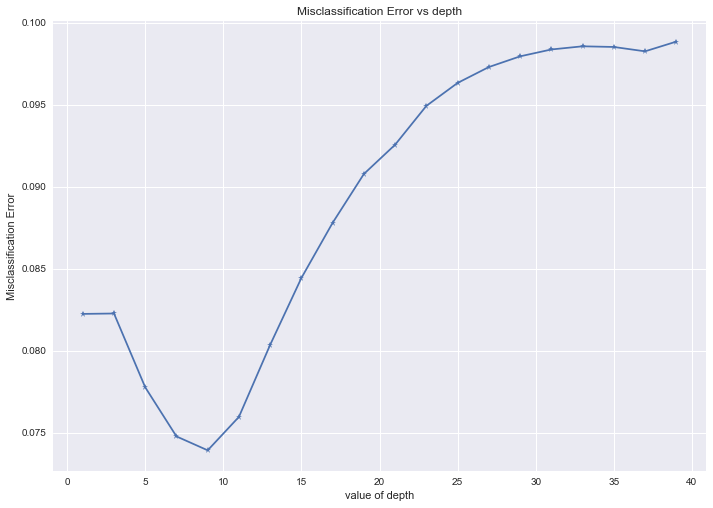

In [58]:
optimal_depth_AvgW2V = RunDT_CV(X_train, y_train)

************************************************************************************************************************
Optimal depth is 9
Accuracy for Decision Tree algorithm is  76.15
F1 score for Decision Tree is  67.29
Recall for Decision Tree is  77.63
Precision for Decision Tree is  66.07

 Classification report for Decision Tree is 
                precision    recall  f1-score   support

          -1       0.37      0.80      0.50     11329
           1       0.95      0.76      0.84     63671

   micro avg       0.76      0.76      0.76     75000
   macro avg       0.66      0.78      0.67     75000
weighted avg       0.87      0.76      0.79     75000



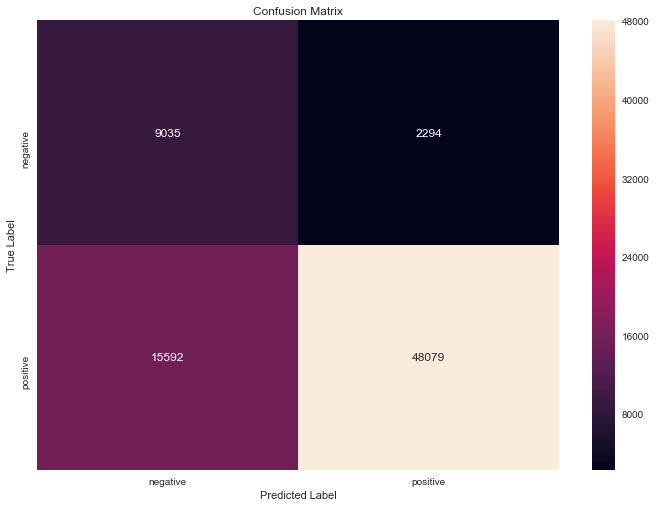

In [59]:
train_err_AvgW2V,test_err_AvgW2V,model_AvgW2V = Run_DT(X_train, y_train,X_test,y_test,optimal_depth_AvgW2V)

# TfIdf W2V

In [60]:
with open('C:/Users/U6069188/Python Projects/Pickle/tfidf_sent_vectors','rb') as f:
    tfidf_sent_vectors = pickle.load(f)

In [61]:
X = np.array(tfidf_sent_vectors)
X.shape

(250000, 50)

In [62]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=.7)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
('max_depth', 7)


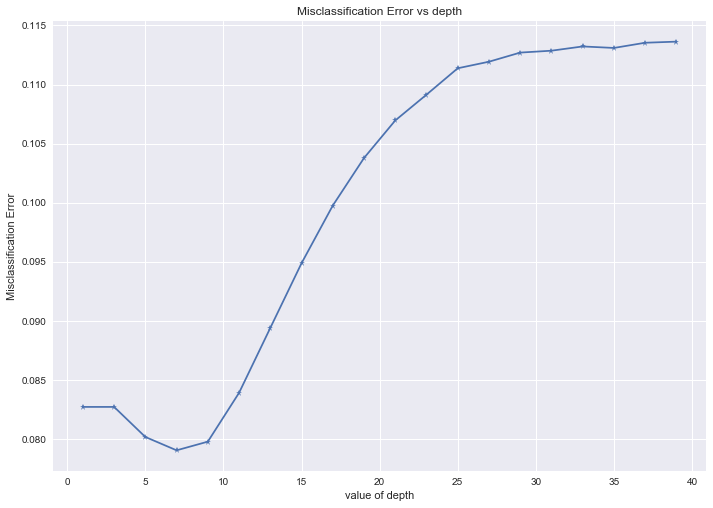

In [63]:
optimal_depth_TfidfW2V = RunDT_CV(X_train, y_train)

************************************************************************************************************************
Optimal depth is 7
Accuracy for Decision Tree algorithm is  71.73
F1 score for Decision Tree is  61.87
Recall for Decision Tree is  71.02
Precision for Decision Tree is  61.84

 Classification report for Decision Tree is 
                precision    recall  f1-score   support

          -1       0.30      0.70      0.42     11179
           1       0.93      0.72      0.81     63821

   micro avg       0.72      0.72      0.72     75000
   macro avg       0.62      0.71      0.62     75000
weighted avg       0.84      0.72      0.75     75000



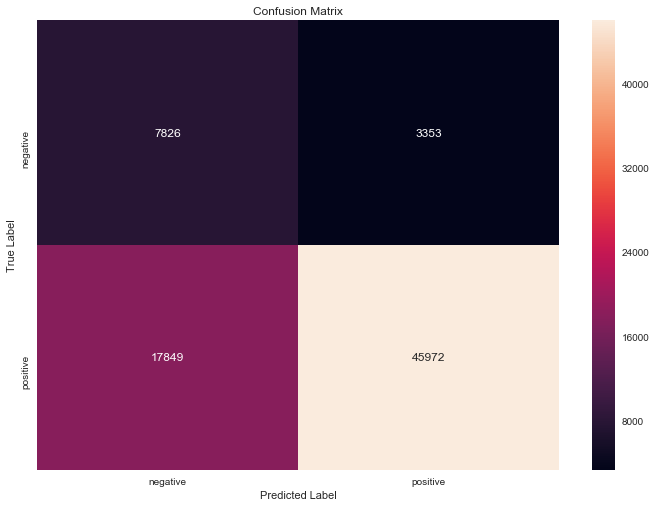

In [64]:
train_err_TfidfW2V,test_err_TfidfW2V,model_TfidfW2V = Run_DT(X_train, y_train,X_test,y_test,optimal_depth_TfidfW2V)

In [65]:
from prettytable import PrettyTable
    
x = PrettyTable()

In [66]:
x.field_names = ["Model", "Optimal Depth", "Train Error", "Test Error"]

In [67]:
x.add_row(["DecisionTreeClassifier For Bow",optimal_depth_bow, train_err_bow*100,101+test_err_bow])
x.add_row(["DecisionTreeClassifier For TfIdf",optimal_depth_tfidf, train_err_tfidf*100,101+test_err_tfidf])
x.add_row(["DecisionTreeClassifier For AvgW2V",optimal_depth_AvgW2V,train_err_AvgW2V*100,101+test_err_AvgW2V])
x.add_row(["DecisionTreeClassifier For tfidfW2V",optimal_depth_TfidfW2V, train_err_TfidfW2V*100,101+test_err_TfidfW2V])

In [68]:
print(x)

+-------------------------------------+---------------+--------------------+--------------------+
|                Model                | Optimal Depth |    Train Error     |     Test Error     |
+-------------------------------------+---------------+--------------------+--------------------+
|    DecisionTreeClassifier For Bow   |       15      | 19.871428571428574 | 25.99333333333334  |
|   DecisionTreeClassifier For TfIdf  |       19      | 17.654285714285713 | 25.673333333333332 |
|  DecisionTreeClassifier For AvgW2V  |       9       | 21.917714285714286 |       25.848       |
| DecisionTreeClassifier For tfidfW2V |       7       | 27.31085714285715  | 30.269333333333336 |
+-------------------------------------+---------------+--------------------+--------------------+


# Obseravtions:
1. Considered only 50K pts for Bow and Tfidf vectorizers, test error is almost same but little better for tfidf vectorizer.
2. Considered 250k points for AvgW2V and TfidfW2V and AvgW2V gave better results.